# Noise2Void - 3D Example for Flywing Data

__Note:__ This notebook expects a trained model and will only work if you have executed the `01_training.ipynb` beforehand.

In [1]:
!pip install tensorflow==2.2.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 516.2 MB 30 kB/s 
     |████████████████████████████████| 20.1 MB 649 kB/s 
     |████████████████████████████████| 2.9 MB 33.5 MB/s 
     |████████████████████████████████| 3.0 MB 36.3 MB/s 
     |████████████████████████████████| 454 kB 75.8 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uni

In [2]:
%%bash
git clone https://github.com/microscopy-processing/n2v.git
cd n2v
pip install -e .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/n2v
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Running setup.py develop for n2v


Cloning into 'n2v'...


In [3]:
import sys
sys.path.append("n2v")

In [4]:
# We import all our dependencies.
from n2v.models import N2V
import numpy as np
from matplotlib import pyplot as plt
from tifffile import imread
from csbdeep.io import save_tiff_imagej_compatible

## Load the Network

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!mkdir models
!mkdir models/n2v_3D

In [7]:
!ls drive/Shareddrives/TomogramDenoising/notebooks/N2V/3D

01_training.ipynb    export.bioimage.io.zip
02_prediction.ipynb  Noise2Void_3D_ZeroCostDL4Mic_NO_FUNCIONA.ipynb
config.json


In [8]:
!cp drive/Shareddrives/TomogramDenoising/notebooks/N2V/3D/export.bioimage.io.zip models/n2v_3D
!cp drive/Shareddrives/TomogramDenoising/notebooks/N2V/3D/config.json models/n2v_3D

In [9]:
# A previously trained model is loaded by creating a new N2V-object without providing a 'config'.
model_name = 'n2v_3D'
basedir = 'models'
model = N2V(config=None, name=model_name, basedir=basedir)

/usr/local/lib/python3.7/dist-packages/csbdeep/models/base_model.py:162: UserWarning: Couldn't find any network weights (*.h5, *.hdf5) to load.
  warnings.warn("Couldn't find any network weights (%s) to load." % ', '.join(weights_ext))


In [10]:
# In case you do not want to load the weights that lead to lowest validation loss during 
# training but the latest computed weights, you can execute the following line:

# model.load_weights('weights_last.h5')

# Download Example Data
Thanks to Romina Piscitello (Eaton Lab, MPI-CBG) for letting us use her data.

In [12]:
import urllib
import os
import zipfile

# create a folder for our data
if not os.path.isdir('./data'):
    os.mkdir('./data')

# check if data has been downloaded already
zipPath='data/flywing-data.zip'
if not os.path.exists(zipPath):
    #download and unzip data
    data = urllib.request.urlretrieve('https://download.fht.org/jug/n2v/flywing-data.zip', zipPath)
    with zipfile.ZipFile(zipPath, 'r') as zip_ref:
        zip_ref.extractall('data')

## Prediction
Here we will simply use the same data as during training and denoise it using our network.

In [13]:
# We load the data we want to process.
img = imread('data/flywing.tif')

# Here we process the data.
# The 'n_tiles' parameter can be used if images are too big for the GPU memory.
# If we do not provide the 'n_tiles' parameter the system will automatically try to find an appropriate tiling.
pred = model.predict(img, axes='ZYX', n_tiles=(2,4,4))

100%|██████████| 16/16 [02:54<00:00, 10.91s/it]


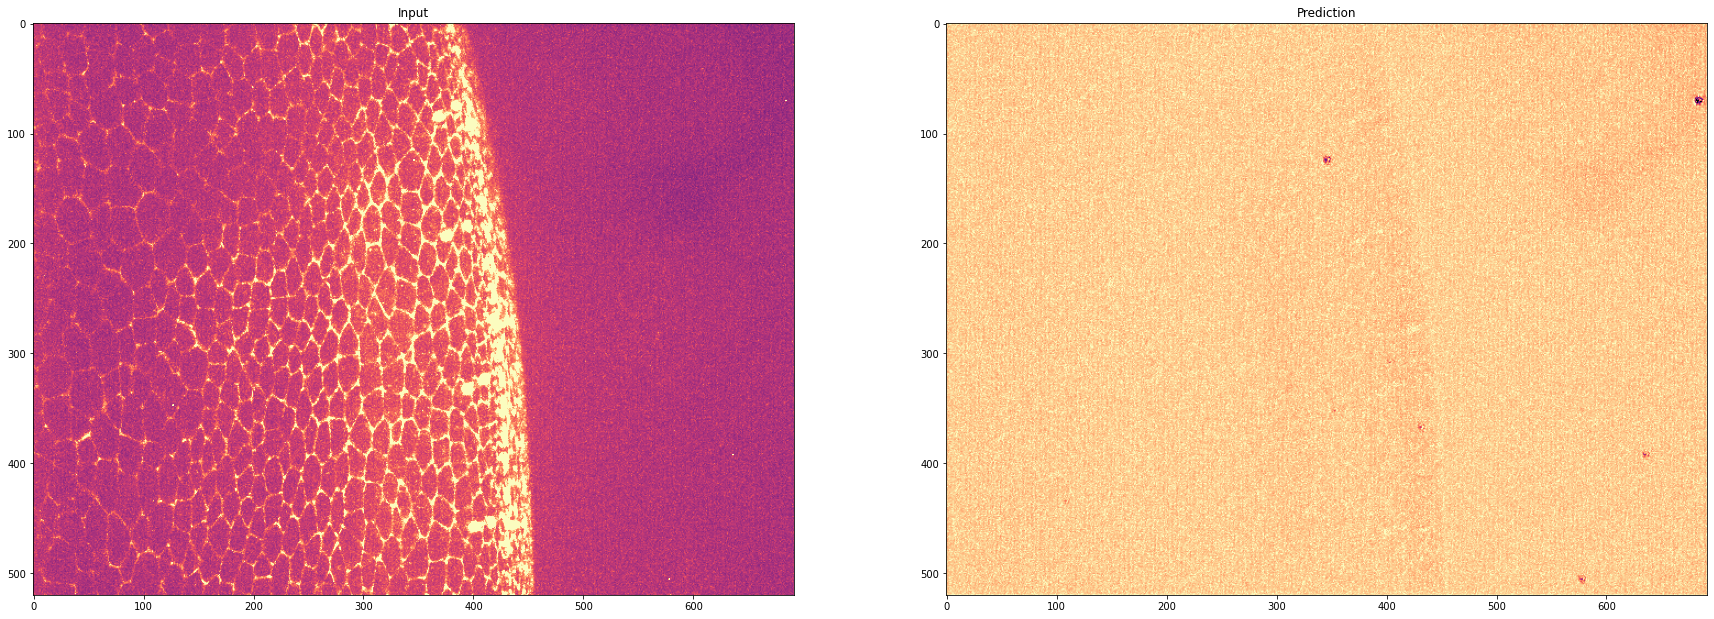

In [14]:
# Let's look at the results.
plt.figure(figsize=(30,30))

# We show the noisy input...
plt.subplot(1,2,1)
plt.imshow(np.max(img,axis=0),
           cmap='magma',
           vmin=np.percentile(img,0.1),
           vmax=np.percentile(img,99.9)
          )
plt.title('Input');

# and the result.
plt.subplot(1,2,2)
plt.imshow(np.max(pred,axis=0), 
           cmap='magma',
           vmin=np.percentile(pred,0.1),
           vmax=np.percentile(pred,99.9)
          )
plt.title('Prediction');

## Save results

In [ ]:
save_tiff_imagej_compatible('prediction.tif', pred, 'ZYX')